In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite
import spectral_analysis as sa
import scipy.interpolate as inter
from scipy.special import erf

In [3]:
epoch_n_91t, wavelength_nugent_91t, flux_nugent_91t = np.loadtxt('../data/info_files/nugent_91t_templates.dat', unpack = True)
epoch_n_91bg, wavelength_nugent_91bg, flux_nugent_91bg = np.loadtxt('../data/info_files/nugent_91bg_templates.dat', unpack = True)

In [49]:
phase_s, wavelength_salt, flux_salt = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_0.dat', unpack = True)
phase_s_corr, wavelength_salt_corr, salt_corr = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_1.dat', unpack = True)
flux_salt_m2 = flux_salt - 3.06*salt_corr #dm15=1.61
flux_salt_p1 = flux_salt + 1.85*salt_corr #dm15=.84
# flux_salt_m2 = flux_salt - 2.68*salt_corr #using fit from guy07
# flux_salt_p1 = flux_salt + 1.76*salt_corr #using fit from guy07

In [50]:
salt_temps_m2 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_m2[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_m2[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_m2[i])
    first = False
    
salt_temps_p1 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_p1[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_p1[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_p1[i])
    first = False

In [51]:
nug_temps_91t = {}
phase_list = []
first = True
for i, phase in enumerate(epoch_n_91t):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            nug_temps_91t[float(epoch_n_91t[i-1]) - 20.] = [temp_wave, temp_flux]
        temp_wave = [wavelength_nugent_91t[i]]
        temp_flux = [flux_nugent_91t[i]]
    else:
        temp_wave.append(wavelength_nugent_91t[i])
        temp_flux.append(flux_nugent_91t[i])
    first = False
    
nug_temps_91bg = {}
phase_list = []
first = True
for i, phase in enumerate(epoch_n_91bg):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            nug_temps_91bg[float(epoch_n_91bg[i-1]) - 20.] = [temp_wave, temp_flux]
        temp_wave = [wavelength_nugent_91bg[i]]
        temp_flux = [flux_nugent_91bg[i]]
    else:
        temp_wave.append(wavelength_nugent_91bg[i])
        temp_flux.append(flux_nugent_91bg[i])
    first = False

In [52]:
def make_obj_from_template(wave, flux):
    wave_s = wave
    flux_s = flux
    wave_interp_s = np.arange(1000., 12000., dtype=int, step=2)
    flux_spl_s = inter.splrep(wave_s, flux_s)
    flux_interp_s = inter.splev(wave_interp_s, flux_spl_s, ext = 3)
    s_template = composite.supernova(wave_interp_s, flux_interp_s)
    s_template.phase_array = np.zeros(len(flux_interp_s))
    return s_template

In [53]:
m2_salt_template = make_obj_from_template(salt_temps_m2[0.][0], salt_temps_m2[0.][1])
p1_salt_template = make_obj_from_template(salt_temps_p1[0.][0], salt_temps_p1[0.][1])
nug91t_template = make_obj_from_template(nug_temps_91t[0.][0], nug_temps_91t[0.][1])
nug91bg_template = make_obj_from_template(nug_temps_91bg[0.][0], nug_temps_91bg[0.][1])

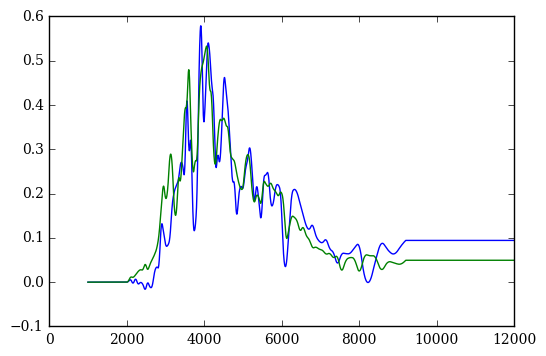

In [54]:
plt.plot(m2_salt_template.wavelength, m2_salt_template.flux)
plt.plot(p1_salt_template.wavelength, p1_salt_template.flux)
plt.show()

In [61]:
query = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -1 and phase <= 1 and ((dm15_source <= .9) or (dm15_from_fits <= .9)) and Supernovae.SN !='2002bf'"]

In [62]:
composites_p1, sn_arrays_p1, boot_sn_arrays_p1 = query_db.main(len(query), query, boot='b', medmean=1, gini_balance=True, verbose=False)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -1 and phase <= 1 and ((dm15_source <= .9) or (dm15_from_fits <= .9)) and Supernovae.SN !='2002bf'
172 questionable files currently ignored
0 questionable spectra removed 23 spectra left
0 Peculiar Ias removed 23 spectra left
23 spectra with host corrections
172 questionable files currently ignored
15 valid SNe found
Arrays cleaned
15 spectra may have telluric contamination
15 SNs with host corrections
Creating composite...
Gini balancing...
Balanced after 4 iterations
Done.
Bootstrapping
scaling boots...
computing confidence intervals...


In [63]:
query_db.set_min_num_spec(composites_p1, 5)

In [64]:
composites_p1[0].name = "Comp"
p1_salt_template.name = "SALT-II"
comps_and_temps = []
for comp in composites_p1:
    comps_and_temps.append(comp)
comps_and_temps.append(p1_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[1], True)

0.851307323133


query_db.py:656: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  comp, arr, boots = composite.main(query_strings[n],boot=boot, medmean = medmean, selection = selection, gini_balance=gini_balance, verbose=verbose)
query_db.py:657: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if store_boots:


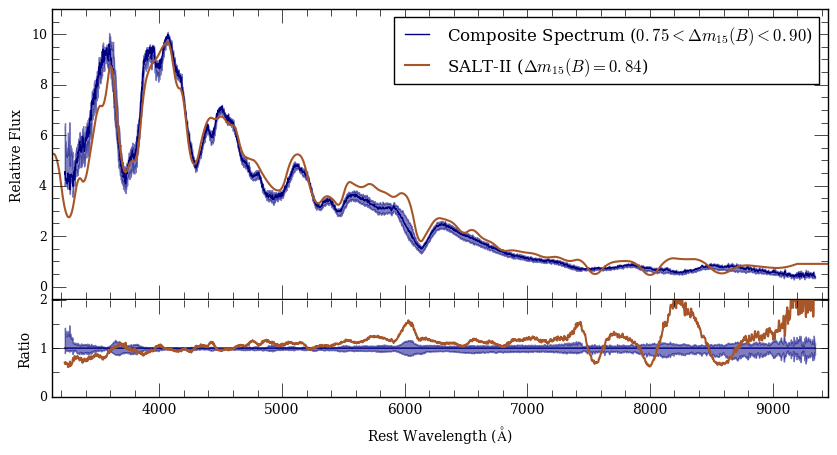

In [65]:
print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1]], legend_labels = ["Composite Spectrum ($ 0.75 < \Delta m_{15} (B) < 0.90$)", "SALT-II ($\Delta m_{15} (B) = 0.84$)"])

In [66]:
query = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and Supernovae.SN !='2002bf'"]

In [67]:
composites_m2, sn_arrays_m2, boot_sn_arrays_m2 = query_db.main(len(query), query, boot='b', medmean=1, gini_balance=True, verbose=False)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and Supernovae.SN !='2002bf'
172 questionable files currently ignored
4 questionable spectra removed 47 spectra left
5 Peculiar Ias removed 42 spectra left
40 spectra with host corrections
172 questionable files currently ignored
13 valid SNe found
Arrays cleaned
13 spectra may have telluric contamination
13 SNs with host corrections
Creating composite...
Gini balancing...
Balanced after 5 iterations
Done.
Bootstrapping
scaling boots...
computing confidence intervals...


In [68]:
query_db.set_min_num_spec(composites_m2, 1)

In [69]:
composites_m2[0].name = "Comp"
m2_salt_template.name = "SALT-II"
comps_and_temps = []
for comp in composites_m2:
    comps_and_temps.append(comp)
comps_and_temps.append(m2_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[1], True)

1.61476110294


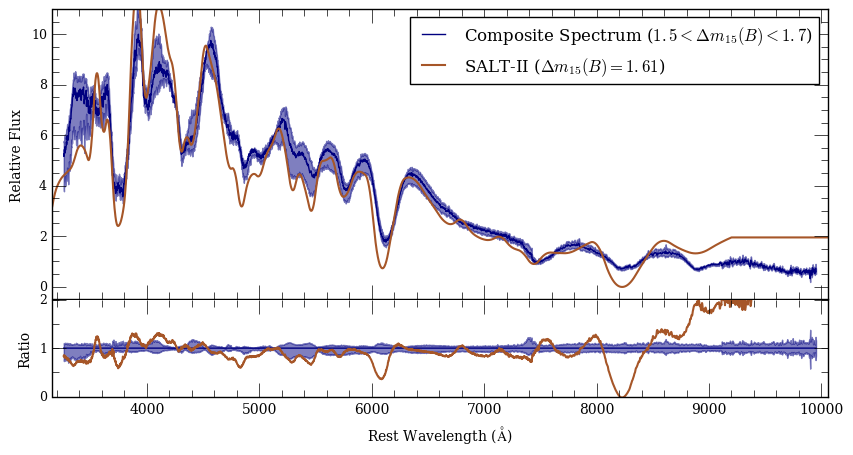

In [72]:
print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1]], 
                     legend_labels = ["Composite Spectrum ($ 1.5 < \Delta m_{15} (B) < 1.7$)", "SALT-II ($\Delta m_{15} (B) = 1.61$)"])

## Warp Hsiao Templates

In [20]:
phase_h, wavelength_hsiao, flux_hsiao = np.loadtxt('../data/info_files/hsiao_template.dat', unpack = True)

In [21]:
hsiao_temps = {}
phase_list = []
first = True
for i, phase in enumerate(phase_h):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            hsiao_temps[float(phase_h[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_hsiao[i]]
        temp_flux = [flux_hsiao[i]]
    else:
        temp_wave.append(wavelength_hsiao[i])
        temp_flux.append(flux_hsiao[i])
    first = False

In [22]:
import pyphot
import scipy.interpolate as inter
import scipy.optimize as opt

In [23]:
def color_residuals(spline_knot_vals, true_BmV, true_VmR, spectrum, Beff = 4315.522317, Veff = 5438.689405, Reff = 6389.952199):
    print spline_knot_vals
    spline_knot_locs = [Beff, Veff, Reff]
    spline = inter.splrep(spline_knot_locs, spline_knot_vals, k=2)
    spline_func = inter.splev(hsiao_max[0], spline, ext = 0)
    warped_flux = spline_func*spectrum[1]

    Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

    Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

    Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag
    
    new_BmV = Bmag - Vmag
    new_VmR = Vmag - Rmag
    print new_BmV, new_VmR
    return (new_BmV - true_BmV)**2. + (new_VmR - true_VmR)**2.
#     return (new_BmV - true_BmV)**2.

In [24]:
lib = pyphot.get_library()
f = lib.find('Johnson')
# for name in f:
#     lib[name].info(show_zeropoints=True)
U = lib['GROUND_JOHNSON_U']
B = lib['GROUND_JOHNSON_B']
V = lib['GROUND_JOHNSON_V']
R = lib['GROUND_COUSINS_R']

In [25]:
phase = 0.
hsiao_max = hsiao_temps[phase]
# Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
# Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
# Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
# Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

In [26]:
# Ueff = 3709.279027
Beff = 4315.522317
Veff = 5438.689405
Reff = 6389.952199
spline_knot_locs = [Beff, Veff, Reff]
spline_knot_vals = [1.00000001, 1.0, 1.0]
spline = inter.splrep(spline_knot_locs, spline_knot_vals, k=2)
spline_func = inter.splev(hsiao_max[0], spline, ext = 0)

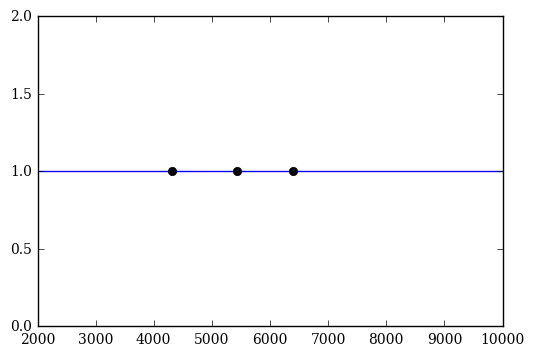

In [27]:
plt.plot(hsiao_max[0], spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.xlim([2000,10000])
plt.ylim([0,2])
plt.show()

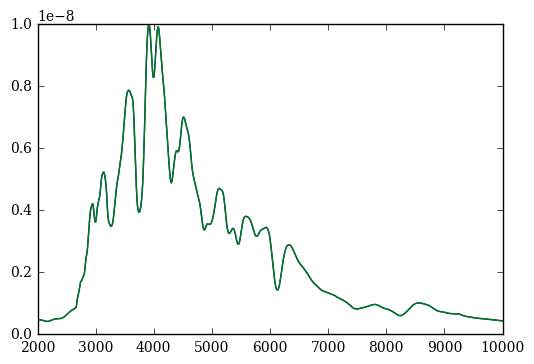

In [28]:
warped_hsiao = spline_func*hsiao_max[1]
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [29]:
Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag

print Bmag, Vmag, Rmag
print Bmag - Vmag, Vmag - Rmag

Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag

print Bmag - Vmag, Vmag - Rmag

-0.0371200866077 0.0423958457655 0.0355232036651
-0.0795159323732 0.00687264210036
-0.079515943888 0.00687264266107


In [31]:
comp = composites_p1[0]

true_Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Bmag = -2.5 * np.log10(true_Bflux) - B.Vega_zero_mag

true_Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Vmag = -2.5 * np.log10(true_Vflux) - V.Vega_zero_mag

true_Rflux = R.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Rmag = -2.5 * np.log10(true_Rflux) - R.Vega_zero_mag

In [32]:
print true_Bmag, true_Vmag, true_Rmag

-22.550880002 -22.4325200133 -22.3438811118


In [33]:
true_BmV = true_Bmag - true_Vmag
true_VmR = true_Vmag - true_Rmag
print true_BmV, true_VmR

-0.118359988666 -0.0886389015904


In [34]:
best_knots = opt.minimize(color_residuals, spline_knot_vals, args = (true_BmV, true_VmR, hsiao_max), method = 'Nelder-Mead').x
print best_knots

[ 1.00000001  1.          1.        ]
-0.079515943888 0.00687264266107
[ 1.05000001  1.          1.        ]
-0.135497477458 0.00966655441418
[ 1.00000001  1.05        1.        ]
-0.0221791626868 -0.0479932773108
[ 1.00000001  1.          1.05      ]
-0.0802701495813 0.0585216073775
[ 1.03333334  1.03333333  0.95      ]
-0.0782875049926 -0.0828109201571
[ 1.05000001  1.05        0.9       ]
-0.0773296001607 -0.158197606426
[ 1.05555557  0.97222222  0.96666667]
-0.173604599397 0.00561625451201
[ 1.0138889   1.03055556  0.99166667]
-0.0600866037679 -0.0350243565209
[ 1.06481483  1.04259259  0.96111111]
-0.102728830612 -0.0785269106788
[ 1.09722223  1.06388889  0.94166667]
-0.113538572985 -0.121389259373
[ 1.02469137  1.07098765  0.93518519]
-0.0259737388164 -0.141269274936
[ 1.04367285  1.01774691  0.9837963 ]
-0.108000233839 -0.027694515666
[ 1.08065845  1.031893    0.9382716 ]
-0.13151350443 -0.0915010295864
[ 1.11404322  1.03256173  0.91157407]
-0.165516898827 -0.1208611721
[ 1.07553

In [35]:
best_spline = inter.splrep(spline_knot_locs, best_knots, k=2)
best_spline_func = inter.splev(hsiao_max[0], best_spline, ext = 0)

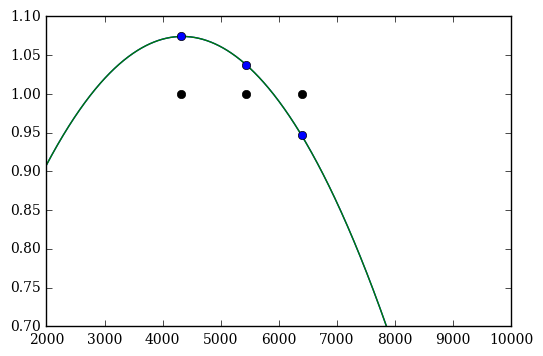

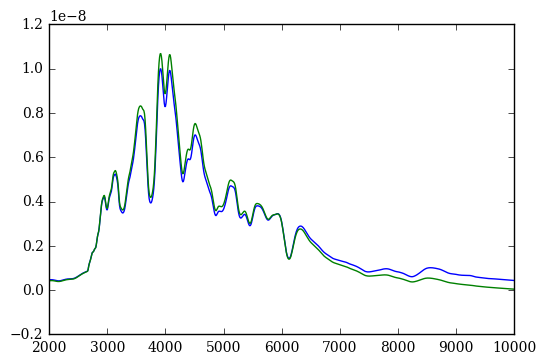

In [36]:
warped_hsiao = best_spline_func*hsiao_max[1]
# plt.plot(hsiao_max[0], hsiao_max[1])
# plt.plot(hsiao_max[0], warped_hsiao)
plt.plot(hsiao_max[0], warped_hsiao/hsiao_max[1])
plt.plot(hsiao_max[0], best_spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.plot(spline_knot_locs, best_knots, 'bo')
plt.xlim([2000,10000])
plt.ylim([.7,1.1])
plt.show()
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [37]:
wave_h = hsiao_max[0]
flux_h = warped_hsiao
wave_interp_h = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_h = inter.splrep(wave_h, flux_h)
flux_interp_h = inter.splev(wave_interp_h, flux_spl_h, ext = 3)
h_template = composite.supernova(wave_interp_h, flux_interp_h)
h_template.phase_array = np.zeros(len(flux_interp_h))

0.851307323133


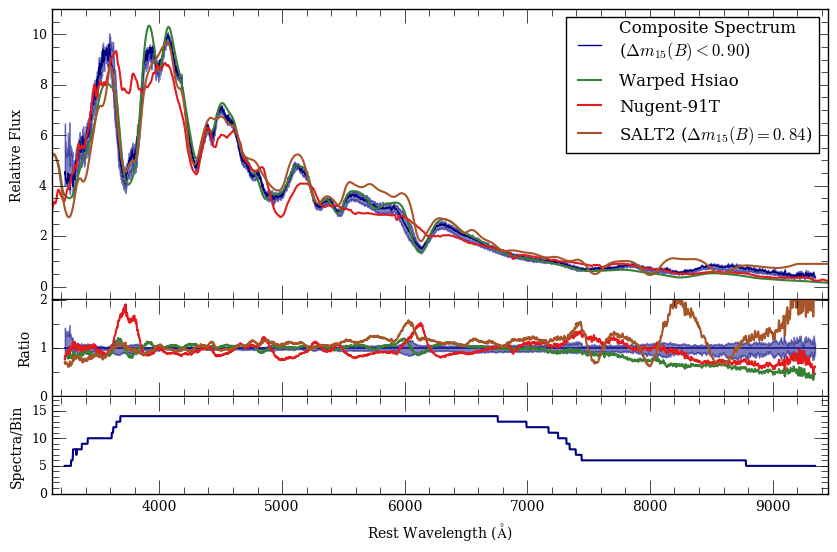

In [73]:
comps_and_temps = []
for comp in composites_p1:
    comps_and_temps.append(comp)
comps_and_temps.append(h_template)
comps_and_temps.append(nug91t_template)
comps_and_temps.append(p1_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[0], True)

comps_and_temps[0].name = "Comp"
comps_and_temps[1].name = "Hsiao"
comps_and_temps[2].name = "Nugent"
comps_and_temps[3].name = "SALT-II"
print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2], comps_and_temps[3]], include_spec_bin=True, 
                     legend_labels = ["Composite Spectrum \n($\Delta m_{15} (B) < 0.90$)", "Warped Hsiao", "Nugent-91T", "SALT2 ($\Delta m_{15} (B) = 0.84$)"],
#                      rm_last_label=True,
                     savename = 'template_comparisons_updated/temp_max_light_lowdm15')

In [39]:
comp = composites_m2[0]

true_Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Bmag = -2.5 * np.log10(true_Bflux) - B.Vega_zero_mag

true_Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Vmag = -2.5 * np.log10(true_Vflux) - V.Vega_zero_mag

true_Rflux = R.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Rmag = -2.5 * np.log10(true_Rflux) - R.Vega_zero_mag

In [40]:
true_BmV = true_Bmag - true_Vmag
true_VmR = true_Vmag - true_Rmag

In [41]:
best_knots = opt.minimize(color_residuals, spline_knot_vals, args = (true_BmV, true_VmR, hsiao_max), method = 'Nelder-Mead').x
print best_knots

[ 1.00000001  1.          1.        ]
-0.079515943888 0.00687264266107
[ 1.05000001  1.          1.        ]
-0.135497477458 0.00966655441418
[ 1.00000001  1.05        1.        ]
-0.0221791626868 -0.0479932773108
[ 1.00000001  1.          1.05      ]
-0.0802701495813 0.0585216073775
[ 0.95000001  1.03333333  1.03333333]
0.017914059335 0.00232544400635
[ 0.90000001  1.05        1.05      ]
0.100069934719 -0.00121737273614
[ 0.93333334  1.06666667  1.06666667]
0.0757990974852 -0.000197307433041
[ 0.8888889   1.11111111  1.02777778]
0.184869735278 -0.0893643962993
[ 0.81481482  1.10185185  1.0962963 ]
0.276540957787 -0.0135109358921
[ 0.87654322  1.0345679   1.11419753]
0.111263147289 0.0777496081582
[ 0.87037038  0.9962963   1.15740741]
0.0730207497347 0.159321339636
[ 0.99176956  0.99897119  1.05761317]
-0.0721055497908 0.0668678254533
[ 0.85905351  1.07613169  1.08662551]
0.184052873883 0.00590520743661
[ 0.82373115  1.04046639  1.1005487 ]
0.191973594165 0.0556337414808
[ 0.80621857 

In [42]:
best_spline = inter.splrep(spline_knot_locs, best_knots, k=2)
best_spline_func = inter.splev(hsiao_max[0], best_spline, ext = 0)

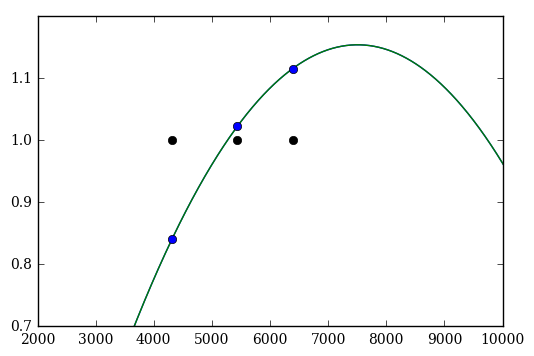

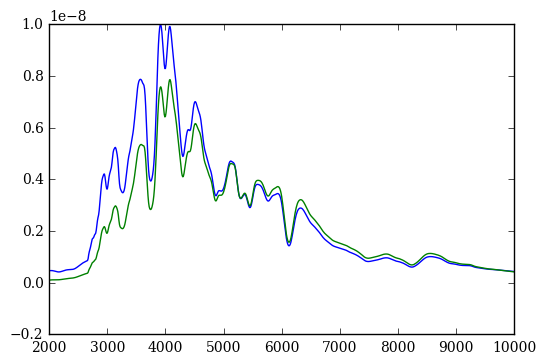

In [43]:
warped_hsiao = best_spline_func*hsiao_max[1]
plt.plot(hsiao_max[0], warped_hsiao/hsiao_max[1])
plt.plot(hsiao_max[0], best_spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.plot(spline_knot_locs, best_knots, 'bo')
plt.xlim([2000,10000])
plt.ylim([.7,1.2])
plt.show()
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [44]:
wave_h = hsiao_max[0]
flux_h = warped_hsiao
wave_interp_h = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_h = inter.splrep(wave_h, flux_h)
flux_interp_h = inter.splev(wave_interp_h, flux_spl_h, ext = 3)
h_template_2 = composite.supernova(wave_interp_h, flux_interp_h)
h_template_2.phase_array = np.zeros(len(flux_interp_h))

query_db.py:657: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  comp.low_conf = norm*comp.low_conf
query_db.py:658: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  comp.up_conf = norm*comp.up_conf


[-5.0, 0.0, 5.0, 10.0, '', 20.0]


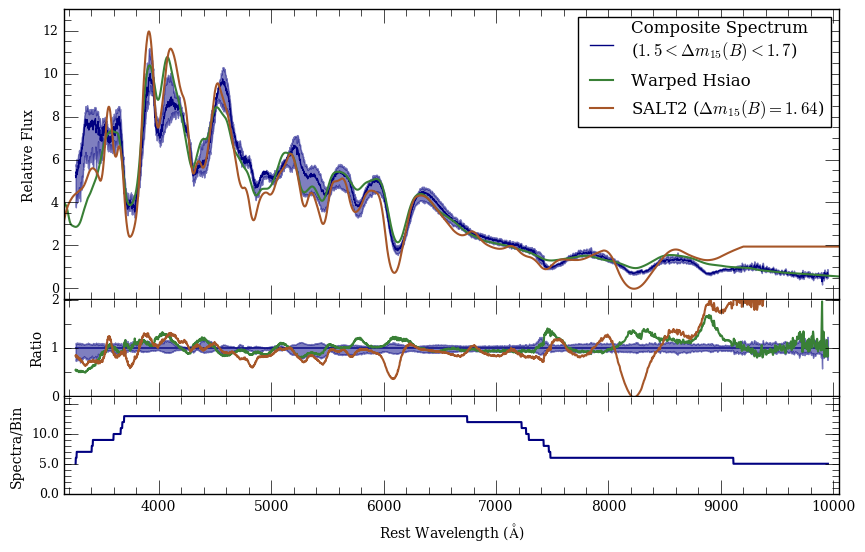

In [76]:
comps_and_temps = []
for comp in composites_m2:
    comps_and_temps.append(comp)
comps_and_temps.append(h_template_2)
comps_and_temps.append(m2_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[0], True)

comps_and_temps[0].name = "Comp"
comps_and_temps[1].name = "Hsiao"
comps_and_temps[2].name = "SALT-II"
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2]], include_spec_bin=True, legend_labels = ["Composite Spectrum \n($ 1.5 < \Delta m_{15} (B) < 1.7$)", "Warped Hsiao", "SALT2 ($\Delta m_{15} (B) = 1.64$)"],
                     rm_last_label=True,
                     savename = 'template_comparisons_updated/temp_max_light_middm15')